### 第6天：TensorFlow2建立模型的三种方式之Model Subclassing API

自定义MLP模型结构，50代，总参数119690，Mnist测试数据集正确率98.26%。对于神经网络而言，可能深比宽好。

In [1]:
import numpy as np
import tensorflow as tf

import os
import shutil
#  绘图
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'SimHei'  # 绘图显示中文 
plt.rcParams['axes.unicode_minus']=False  # 绘图显示负号

print('tensorflow版本：', tf.__version__)
import sys
print('Python版本：', sys.version.split('|')[0])

tensorflow版本： 2.1.0
Python版本： 3.7.6 


基于模型子类化的方式可以更为灵活的构建模的层和模型，通过继承TensorFlow中定义的类，编写正向传递输出，也就是定义call函数。但是并不用考虑模型的的反向传递，因为会自动计算梯度。 

+ ### 1、自定义模型的层

自定义模型的层，就是可以按照自己的想法建立层，而不直接调用框架内置的模型层。可以通过tf.keras.Lambda或继承tf.keras.layers.Layer基类构建自定义模型层。

- #### tf.keras.Lambda

注意使用该方法创建的层，如果里面涉及到变量的话，并不会将该变量自动的加入到需要计算梯度的变量集合中。因此如果自定义的层中有需要被训练的参数，建议使用基于基类的方式自定义模型层。下面给出示例：

In [2]:
#  定义一个全连接层：参数为变量
weights = tf.Variable(tf.random.normal((4, 2)), name='w')
bias = tf.ones((1, 2), name='b')
print(bias)
x_input = tf.range(12.).numpy().reshape(-1, 4)

# lambda 自定义层
mylayer1 = tf.keras.layers.Lambda(lambda x: tf.add(tf.matmul(x, weights), bias), name='lambda1')
mylayer1(x_input)

tf.Tensor([[1. 1.]], shape=(1, 2), dtype=float32)
The following Variables were used a Lambda layer's call (lambda1), but
are not present in its tracked objects:
  <tf.Variable 'w:0' shape=(4, 2) dtype=float32, numpy=
array([[ 0.8078063 , -0.26994967],
       [-2.652554  , -0.86710316],
       [ 0.09493118,  0.6912361 ],
       [ 0.6136994 ,  0.33947706]], dtype=float32)>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 0.3784064,  2.5338001],
       [-4.166062 ,  2.1084414],
       [-8.710529 ,  1.6830826]], dtype=float32)>

上面的警告说明，该层中的变量名为'w'的变量没有在计算梯度的项目中，如果不是有意为之的话，建议使用基于基类的方式而不是Lambda来定义层。

In [3]:
# 利用lambda构建一个稍微复杂的层:反校正层
def lambda_layer(x, name='反校正'):
    x -= tf.reduce_mean(x, axis=1, keepdims=True)
    x = tf.math.l2_normalize(x, axis=1)
    pos = tf.nn.relu(x)
    neg = tf.nn.relu(-x)
    return tf.keras.layers.concatenate([pos, neg], axis=1)

x_input = tf.range(6.).numpy().reshape(3, 2)
lambda_layer(x_input).numpy()

array([[0.        , 0.70710677, 0.70710677, 0.        ],
       [0.        , 0.70710677, 0.70710677, 0.        ],
       [0.        , 0.70710677, 0.70710677, 0.        ]], dtype=float32)

- #### 继承tf.keras.layers.Layer

继承**tf.keras.layers.Layer**, 主要重写**__init__()** 和**call()** 这两个方法，在第一个方法中声明用到的参数和函数，在第二个方法中定义该层的输出。如果需要更改层的基础参数，例如更改全连接层中的初始参数，则需要重写**build()**。下面给出自定义一个全连接层的示例：

In [4]:
# 自定义一个全连接层
class MyLayerD(tf.keras.layers.Layer):   # 继承类
    def __init__(self, outputdim, func, **kwargs):  
        super().__init__(**kwargs)
        self.output_dim = outputdim  # 下一层的单元的个数，
        self.activatefunc = func  # 激活函数
        
    # 通过build初始化参数
    def build(self, input_shape):  # 该函数会根据输入的数据，自动获得输入的维度
        self.w = self.add_weight(name='weights', shape=(input_shape[1], self.output_dim), initializer='uniform', trainable=True)
        self.b = self.add_weight(name='bias', shape=(1, self.output_dim), initializer='uniform', trainable=True)
        
    # 定义输出
    def call(self, inputdata):
        x = tf.add(tf.matmul(inputdata, self.w), self.b)  # 全连接
        output = self.activatefunc(x)  # 激活函数
        return output
    
# 构造输入数据
x_input = tf.range(6.).numpy().reshape(2, 3) 

# 定义层
mylayer2 = MyLayerD(2, tf.nn.relu)  

# 该层的输出
mylayer2(x_input)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.06674077, 0.1107444 ],
       [0.16843538, 0.21887344]], dtype=float32)>

+ ### 2、自定义模型

继承tf.keras.Model类，主要重写**__init__()** 和**call()** 这两个方法，在第一个方法中声明用到的参数和函数，在第二个方法中定义该层的输出。如果需要展示模型的结构，则需要重写**build()** 方法，下面给出自定义一个MLP模型的示例：

In [5]:
# 自定义MLP
class MyModelMLP(tf.keras.Model):
    def __init__(self, input_shape, **kwargs):
        super().__init__(**kwargs)  
        
        self.mylayer1 = MyLayerD(10, tf.nn.relu, name='MyLayer_D1')  # 自定义层 
        self.mylayer2 = MyLayerD(20, tf.nn.relu, name='MyLayer_D2')  # 自定义层
        self.layer1 = tf.keras.layers.Dense(30, activation='relu', name='DENSE_1')   # 内置全连接层
        self.mylayer3 = MyLayerD(1, tf.nn.relu, name='MyLayer_D3')  # 自定义层
        
        # 模型的参数
        self.input_layer = tf.keras.layers.Input(input_shape)
        self.out = self.call(self.input_layer)
        super().__init__( inputs=self.input_layer,outputs=self.out,**kwargs)
        
    # 初始化模型的参数
    def build(self):
        self._is_graph_network = True
        self._init_graph_network(inputs=self.input_layer,outputs=self.out)
        
    # 定义模型的正向传递               
    def call(self, inputdata):
        x = self.mylayer1(inputdata)
        x = self.mylayer2(x)
        x = self.layer1(x)
        x = lambda_layer(x)  # 自定义Lambda层
        output = self.mylayer3(x)
        return output

### 2.1 输出自定义模型的概述

In [6]:
# 构造输入数据
x_input2 = tf.range(6.).numpy().reshape(2, 3) 
mymodel1 = MyModelMLP(3, name='MyModelMLP')
mymodel1(x_input2)
mymodel1.summary()

Model: "MyModelMLP"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
MyLayer_D1 (MyLayerD)           (None, 10)           40          input_1[0][0]                    
__________________________________________________________________________________________________
MyLayer_D2 (MyLayerD)           (None, 20)           220         MyLayer_D1[0][0]                 
__________________________________________________________________________________________________
DENSE_1 (Dense)                 (None, 30)           630         MyLayer_D2[0][0]                 
_________________________________________________________________________________________

### 2.2 输出自定义模型的结构

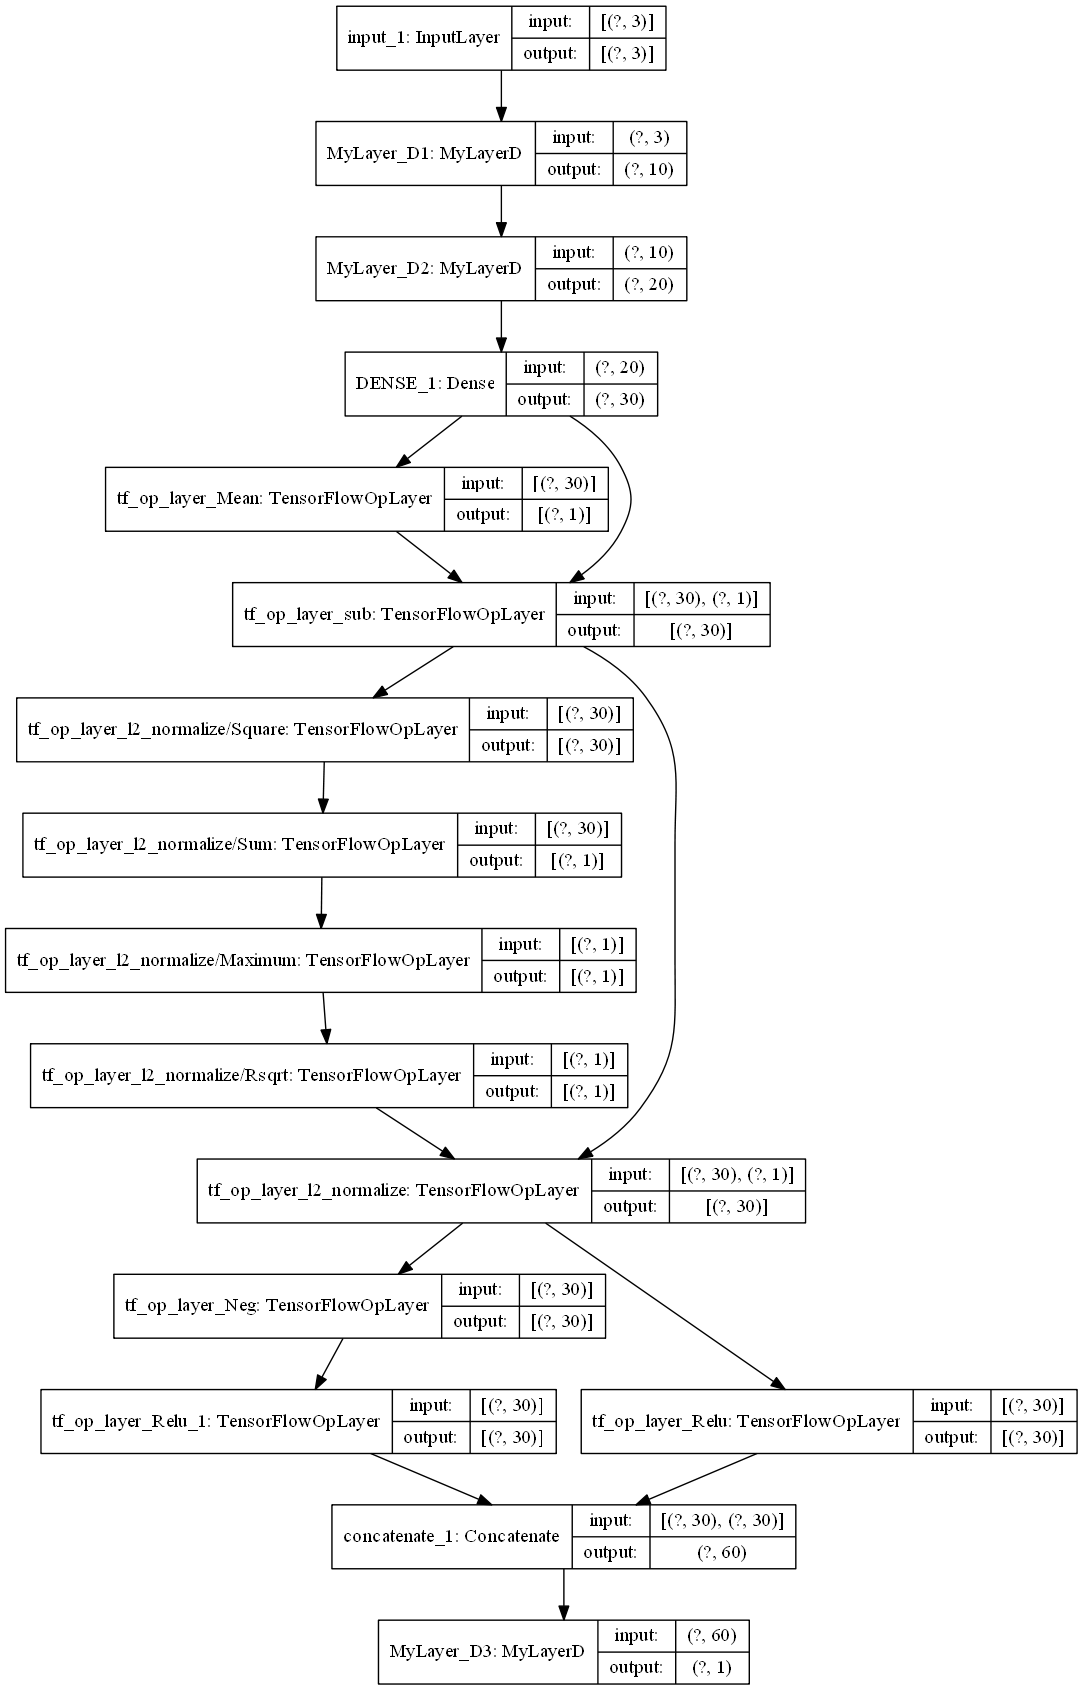

In [7]:
tf.keras.utils.plot_model(mymodel1, to_file='mymodel1.png', show_shapes=True, 
                          show_layer_names=True,rankdir='TB', dpi=100, expand_nested=True)

### 3 自定义模型应用实例

+ #### 3.1 mnist数据集准备

数据集的介绍可参见第四天的内容。

In [8]:
from tensorflow.keras.datasets import mnist
mnistdata = mnist.load_data()

In [9]:
(train_features, train_labels), (test_features, test_labels) = mnistdata

In [10]:
# 归一化
trainfeatures = train_features / 255
testfeatures = test_features / 255

In [11]:
# 平铺
train_fea = trainfeatures.reshape(-1, 784)
test_fea = testfeatures.reshape(-1, 784)

+ #### 3.2 构建自定义MLP模型

In [12]:
 # 利用lambda构建一个连接层
def lambda_layer(x, y):
    return tf.keras.layers.concatenate([x, y], axis=1)

In [13]:
tf.keras.backend.set_floatx('float64')
# 自定义MLP
class MyMODEL(tf.keras.Model):
    def __init__(self, input_shape, **kwargs):
        super().__init__(**kwargs) 

        self.mylayer11 = MyLayerD(64, tf.nn.relu, name='MyLayer_D11')  # 自定义层 
        self.mylayer12 = MyLayerD(128, tf.nn.relu, name='MyLayer_D12')  # 自定义层

        
        self.mylayer21 = MyLayerD(64, tf.nn.relu, name='MyLayer_D21')  # 自定义层 
        self.mylayer22 = MyLayerD(128, tf.nn.relu, name='MyLayer_D22')  # 自定义层
        
        
        self.dropout1 = tf.keras.layers.Dropout(rate=0.5, name='dropout1') # 内置层，丢弃层，防止过拟合
        self.mylayer3 = MyLayerD(10, tf.nn.softmax, name='MyLayer_D3')  # 自定义层
        
        
        # 模型的参数
        self.input_layer = tf.keras.layers.Input(input_shape)
        self.out = self.call(self.input_layer)
        
        super().__init__( inputs=self.input_layer,outputs=self.out, **kwargs)
        
    # 初始化模型的参数
    def build(self):
        self._is_graph_network = True
        self._init_graph_network(inputs=self.input_layer,outputs=self.out)
        
    # 定义模型的正向传递               
    def call(self, inputdata, **kwargs):
        
        x1 = self.mylayer11(inputdata)
        x1 = self.mylayer12(x1)

        x2 = self.mylayer21(inputdata)
        x2 = self.mylayer22(x2)
        

        x12 = lambda_layer(x1, x2)  # Lambda自定义层
   
        
        x = self.dropout1(x12)
        
        output = self.mylayer3(x)

        return output

+ #### 3.3 自定义MLP模型概述

In [14]:
mymodel2 = MyMODEL(784, name='MyModelMLP')
mymodel2(train_fea)
mymodel2.summary()

Model: "MyModelMLP"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
MyLayer_D11 (MyLayerD)          (None, 64)           50240       input_2[0][0]                    
__________________________________________________________________________________________________
MyLayer_D21 (MyLayerD)          (None, 64)           50240       input_2[0][0]                    
__________________________________________________________________________________________________
MyLayer_D12 (MyLayerD)          (None, 128)          8320        MyLayer_D11[0][0]                
_________________________________________________________________________________________

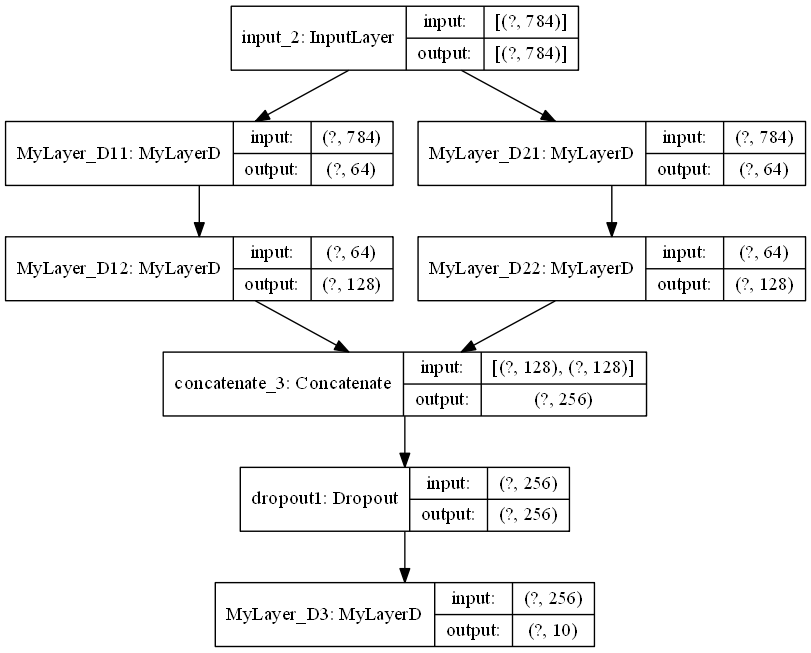

In [15]:
tf.keras.utils.plot_model(mymodel2, to_file='mymodel2.png', show_shapes=True, 
                          show_layer_names=True, rankdir='TB', dpi=100, expand_nested=True)

+ #### 3.4 模型训练

In [16]:
Epoch = 50  # 模型迭代的次数
Batch_Size = 128  # 批量训练的样本的个数
Out_Class = 10  # 输出的类别的个数,0-9共10类

In [17]:
# 模型编译
mYMODEL = MyMODEL(784)
mYMODEL.compile(optimizer='Sgd', loss='categorical_crossentropy', metrics=['accuracy'])  
train_label_cate = tf.keras.utils.to_categorical(train_labels, 10)
testlabels = tf.keras.utils.to_categorical(test_labels, 10)

In [18]:
import os

checkpoint_path = "./cp-{val_accuracy:.5f}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 创建一个回调，保证验证数据集准确率最大
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 verbose=2,
                                                 save_best_only=True)

# 动态更改学习率：在模型的回调中使用
def scheduler(epoch):  # 根据epoch动态更改学习率的参数
    if epoch < 20:
        return 0.43
    else:
        return 0.43 * tf.math.exp(0.1 * (20 - epoch))
    
lr_back = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [19]:
mYMODEL.fit(train_fea, train_label_cate, batch_size=Batch_Size, 
            epochs=Epoch, verbose=2, validation_split=0.1, 
            callbacks=[cp_callback, lr_back])
 

Train on 54000 samples, validate on 6000 samples
Epoch 1/50

Epoch 00001: val_accuracy improved from -inf to 0.95233, saving model to ./cp-0.95233.ckpt
54000/54000 - 3s - loss: 0.5527 - accuracy: 0.8255 - val_loss: 0.1552 - val_accuracy: 0.9523
Epoch 2/50

Epoch 00002: val_accuracy improved from 0.95233 to 0.97167, saving model to ./cp-0.97167.ckpt
54000/54000 - 3s - loss: 0.1854 - accuracy: 0.9441 - val_loss: 0.0988 - val_accuracy: 0.9717
Epoch 3/50

Epoch 00003: val_accuracy improved from 0.97167 to 0.97617, saving model to ./cp-0.97617.ckpt
54000/54000 - 3s - loss: 0.1324 - accuracy: 0.9597 - val_loss: 0.0826 - val_accuracy: 0.9762
Epoch 4/50

Epoch 00004: val_accuracy did not improve from 0.97617
54000/54000 - 2s - loss: 0.1037 - accuracy: 0.9681 - val_loss: 0.0819 - val_accuracy: 0.9757
Epoch 5/50

Epoch 00005: val_accuracy improved from 0.97617 to 0.97867, saving model to ./cp-0.97867.ckpt
54000/54000 - 3s - loss: 0.0888 - accuracy: 0.9727 - val_loss: 0.0748 - val_accuracy: 0.978

In [20]:
# 评估模型,按照模型最后的参数计算
test_loss, test_acc = mYMODEL.evaluate(test_fea, testlabels)

print('测试数据集成本：{:.8f},准确率{:.8f}%'. format(test_loss, 100*test_acc))

10000/10000 [==============================] - 0s 45us/sample - loss: 0.0867 - accuracy: 0.9824
测试数据集成本：0.08670917,准确率98.24000000%


+ #### 3.5 模型加载

In [21]:
# 参数加载
# 新的模型结构保持一致。
model_new = MyMODEL(784)
# 需要经过编译，参数也要和原来的一致
model_new.compile(optimizer='Sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# 加载已经训练好的参数
best_para = tf.train.latest_checkpoint(checkpoint_dir)
print('最优的参数文件：', best_para)
model_new.load_weights(best_para)
predict_loss, predict_acc = model_new.evaluate(test_fea, testlabels)
print('使用训练后的参数','成本:', predict_loss, '准确率%.4f%%' % (100*predict_acc))

最优的参数文件： .\cp-0.98367.ckpt
10000/10000 [==============================] - 1s 69us/sample - loss: 0.0842 - accuracy: 0.9826
使用训练后的参数 成本: 0.08417692760290683 准确率98.2600%
